In [1]:
import chipwhisperer as cw

scope                  = cw.scope()
scope.gain.db          = 25
scope.adc.samples      = 200
scope.adc.offset       = 0
scope.adc.basic_mode   = "rising_edge"

scope.trigger.triggers = "tio4"
scope.io.tio1          = "serial_rx"
scope.io.tio2          = "serial_tx"
scope.io.hs2           = "disabled"

Next we set all the PLLs. We enable CW305's PLL1; this clock will feed both the target and the CW ADC. As explained [here](http://wiki.newae.com/Tutorial_CW305-1_Building_a_Project#Capture_Setup), **make sure the DIP switches on the CW305 board are set as follows**:
- J16 = 0
- K16 = 1

In [2]:
#target = cw.target(scope, cw.targets.CW305, fpga_id='100t', force=True)
target = cw.target(scope, cw.targets.CW305, bsfile=r"/media/sf_cw_data_repo/fpga_ascon/cw305_top.bit", force=True)

In [3]:
target.vccint_set(1.0)
# we only need PLL1:
target.pll.pll_enable_set(True)
target.pll.pll_outenable_set(False, 0)
target.pll.pll_outenable_set(True, 1)
target.pll.pll_outenable_set(False, 2)

# run at 10 MHz:
target.pll.pll_outfreq_set(10E6, 1)

# 1ms is plenty of idling time
target.clkusbautooff = True
target.clksleeptime  = 1

In [4]:
#ensure ADC is locked
scope.clock.adc_src = "extclk_x4"
scope.clock.reset_adc()
assert (scope.clock.adc_locked), "ADC failed to lock"

In [5]:
project_file = "projects/Tutorial_HW_CW305.cwp"
project = cw.create_project(project_file, overwrite=True)

In [6]:
import tqdm
import numpy as np
import time

ktp     = cw.ktp.Basic()

traces  = []
noncein  = []
keys    = []
initialization_out = []

N       = 100000 # Number of traces

# initialize cipher to verify DUT result:
fixed_key, _ = ktp.next()
target.fpga_write(target.REG_CRYPT_KEY,fixed_key)

for i in tqdm.tnrange(N, desc='Capturing traces'):

    #arm the scope
    scope.arm()
    
    #write the plaintext
    
    _, nonce = ktp.next()  
    target.fpga_write(target.REG_CRYPT_TEXTIN,nonce)
    noncein.append(nonce)
    keys.append(fixed_key)
    
    target.fpga_write(target.REG_USER_LED,[0x01])
    target.usb_trigger_toggle()
    
    ret = scope.capture()
    
    if ret:
        print("Failed capture")
        continue

    output = target.fpga_read(target.REG_CRYPT_CIPHEROUT,16)
    wave   = scope.get_last_trace()
    
    initialization_out.append(output)
        
    traces.append(wave)

/home/vagrant/.pyenv/versions/3.7.7/envs/cw/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Capturing traces:   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
project.save()
scope.dis()
target.dis()

In [8]:
import scipy.io

acquisition_number = 10
filename = 'fpga_ascon_100k_acq_'+str(acquisition_number)+'.mat'
mdic = {'traces': np.array(traces), 'nonce': np.array(noncein), 'initialization_out': np.array(initialization_out),'keys': np.array(keys)}
scipy.io.savemat('/media/sf_cw_data_repo/fpga_ascon/'+filename,mdic)

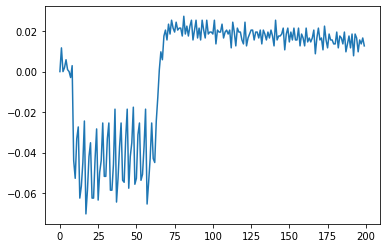

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.array(traces)[0,:])